In [95]:
import os
import pandas as pd

###
# This script is used to extract measurement data from the raw logs
##
testfile = "data/raw_logs/2023_02_09_1700_multi_ho.log"


def extract_log_data(logfile):
    with open(logfile, "r") as f:
        log_data = f.readlines()
    log_data = [x.strip() for x in log_data]
    log_data = [
        [x[:26], x[28:35].strip(), x[38:39], x[41:]] for x in log_data if x != ""
    ]
    log_data = pd.DataFrame(
        log_data, columns=["timestamp", "thread", "level", "message"]
    )
    return log_data


# # Sample logs:
# # 2024-02-09T17:05:40.122260 [RRC    ] [I] Proc "Handover" - Starting...
# # 2024-02-09T17:05:40.122272 [RRC    ] [I] Proc "Handover" - Received HO command to target PCell=1
# # 2024-02-09T17:05:40.383121 [RRC    ] [I] Proc "Handover" - HO to PCI=1, EARFCN=3350 successful
# def extract_ho_data(logfile):
#     log_data = log_data[log_data['message'].str.contains('Proc "Handover"', na=False)]
#     log_data[['timestamp','message']] = log_data.message.str.extract(r'Proc "Handover" - (Received HO command to target PCell=|HO to PCI=)(.*), EARFCN=(.*) successful')
#     log_data['timestamp'] = pd.to_datetime(log_data['timestamp'])
#     log_data['pci'] = log_data['pci'].astype(int)
#     log_data['earfcn'] = log_data['earfcn'].astype(int)
#     return log_data


def extract_measurement_data(logfile):
    log_data = log_data[
        log_data["message"].str.contains("MEAS:  New measurement", na=False)
    ]
    log_data[["measurement_type", "earfcn", "pci", "rsrp", "cfo"]] = (
        log_data.message.str.extract(
            r"MEAS:  New measurement (serving|neighbour) cell: earfcn=(.*), pci=(.*), rsrp=(.*) dBm, cfo=(.*) Hz"
        )
    )
    log_data = log_data[["timestamp", "measurement_type", "pci", "rsrp"]]
    log_data["timestamp"] = pd.to_datetime(log_data["timestamp"])
    log_data["pci"] = log_data["pci"].astype(int)
    log_data["rsrp"] = log_data["rsrp"].astype(float)
    return log_data


def smoothed_rsrp(log_data, window_ms=50):
    cells = []
    # smooth rsrp values within each pci
    smooth_data = log_data.copy()
    smooth_data.set_index("timestamp", inplace=True)
    for pci in log_data.pci.unique():
        smooth_data.loc[smooth_data.pci == pci, "rsrp"] = (
            smooth_data.loc[smooth_data.pci == pci, "rsrp"]
            .rolling(window=f"{window_ms}ms")
            .mean()
        )

    smooth_data.reset_index(inplace=True)
    return smooth_data


log_data = get_measurement_data(testfile)
print(log_data.head(10))
print(smoothed_rsrp(log_data).head(10))

                    timestamp measurement_type  pci   rsrp
21 2024-02-09 17:01:50.093195          serving    1 -72.67
25 2024-02-09 17:01:50.113236          serving    1 -72.69
46 2024-02-09 17:01:50.133247          serving    1 -72.67
47 2024-02-09 17:01:50.153273          serving    1 -72.69
48 2024-02-09 17:01:50.172192          serving    1 -72.69
49 2024-02-09 17:01:50.192221          serving    1 -71.59
50 2024-02-09 17:01:50.213187          serving    1 -74.56
51 2024-02-09 17:01:50.233218          serving    1 -74.97
85 2024-02-09 17:01:50.254274          serving    1 -74.97
99 2024-02-09 17:01:50.274147          serving    1 -75.71
                   timestamp measurement_type  pci       rsrp
0 2024-02-09 17:01:50.093195          serving    1 -72.670000
1 2024-02-09 17:01:50.113236          serving    1 -72.680000
2 2024-02-09 17:01:50.133247          serving    1 -72.676667
3 2024-02-09 17:01:50.153273          serving    1 -72.683333
4 2024-02-09 17:01:50.172192          ser

Handover: 1 -> 2 at 2024-02-09 17:04:49.784957
Handover: 2 -> 1 at 2024-02-09 17:05:40.355114


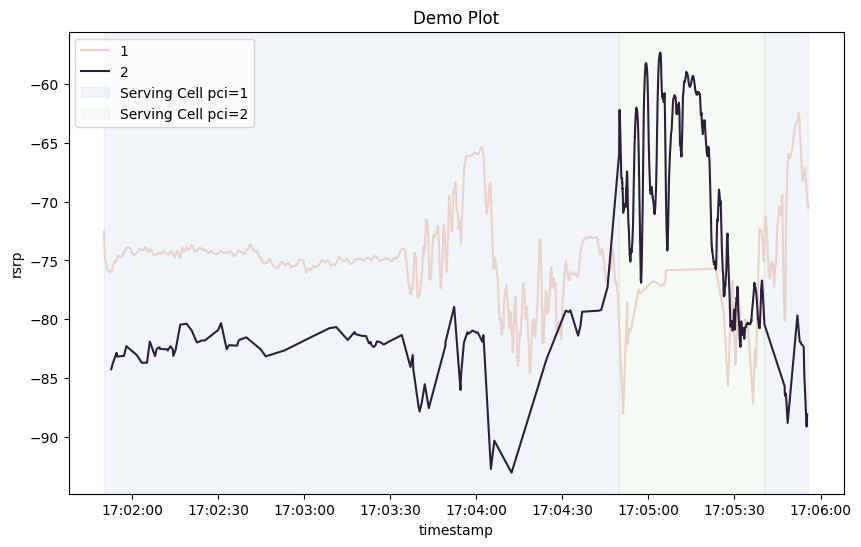

In [101]:
###
# Plotting the logs
##

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

log_data = get_measurement_data(testfile)
smoothed_data = smoothed_rsrp(log_data, window_ms=1000)


def plot_rsrp_vs_time(log_data, print_handover=False, title="RSRP vs Time"):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x="timestamp", y="rsrp", data=log_data, hue="pci", ax=ax)
    plt.title(title)
    # Show current serving cell
    serving_cell = log_data[log_data["measurement_type"] == "serving"]
    pcis_labelled = []
    # Shade in background to indicate serving cell's pci
    current_pci = serving_cell["pci"].values[0]
    current_timestamp = serving_cell["timestamp"].values[0]
    for i, row in serving_cell.iterrows():
        if row["pci"] != current_pci:
            if print_handover:
                print(
                    "Handover:", f"{current_pci} -> {row['pci']} at {row['timestamp']}"
                )
            cmap = plt.get_cmap("Pastel1")
            if current_pci not in pcis_labelled:
                pcis_labelled.append(current_pci)
                ax.axvspan(
                    current_timestamp,
                    row["timestamp"],
                    color=cmap(current_pci),
                    alpha=0.2,
                    label=f"Serving Cell pci={current_pci}",
                )
            else:
                ax.axvspan(
                    current_timestamp,
                    row["timestamp"],
                    color=cmap(current_pci),
                    alpha=0.2,
                )
            current_pci = row["pci"]
            current_timestamp = row["timestamp"]
    cmap = plt.get_cmap("Pastel1")
    if current_pci not in pcis_labelled:
        pcis_labelled.append(current_pci)
        ax.axvspan(
            current_timestamp,
            row["timestamp"],
            color=cmap(current_pci),
            alpha=0.2,
            label=f"Serving Cell pci={current_pci}",
        )
    else:
        ax.axvspan(
            current_timestamp, row["timestamp"], color=cmap(current_pci), alpha=0.2
        )
    plt.legend(loc="upper left")
    plt.show()


plot_rsrp_vs_time(smoothed_data, print_handover=True, title="Demo Plot")

Plotting data/raw_logs/2023_02_09_1700_multi_ho.log:
Handover: 1 -> 2 at 2024-02-09 17:04:49.784957
Handover: 2 -> 1 at 2024-02-09 17:05:40.355114


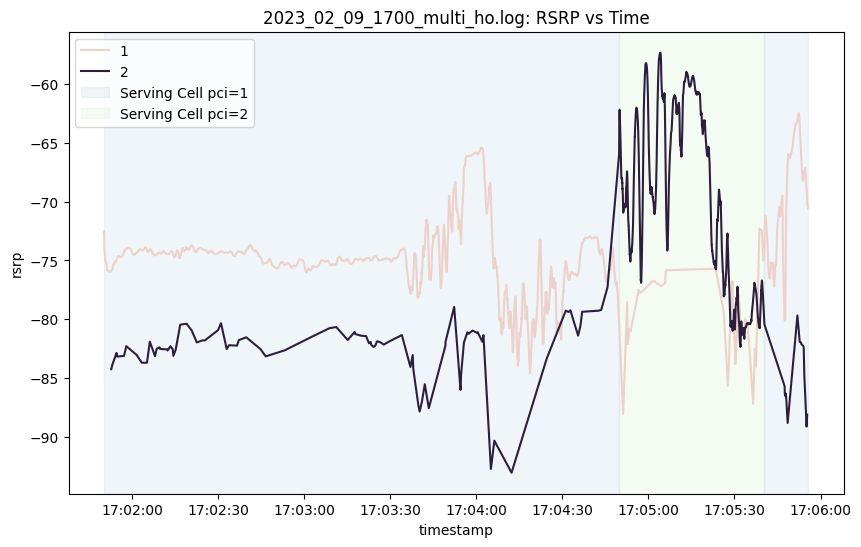

Plotting data/raw_logs/2023_02_09_1715_rotating.log:
Handover: 2 -> 1 at 2024-02-09 17:13:45.263682
Handover: 1 -> 2 at 2024-02-09 17:14:13.307742
Handover: 2 -> 1 at 2024-02-09 17:14:23.243766


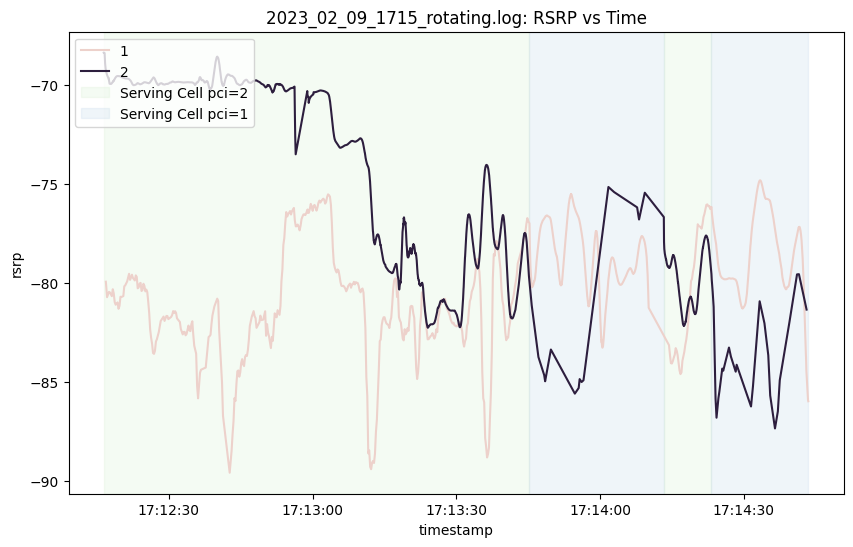

Plotting data/raw_logs/2023_02_09_1720_wait.log:
Handover: 2 -> 1 at 2024-02-09 17:19:18.064634


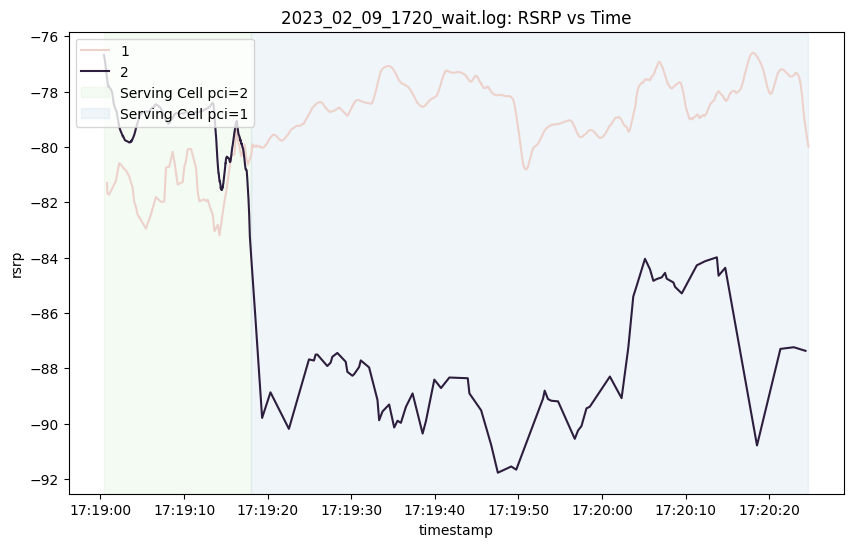

Plotting data/raw_logs/2023_02_09_1726_walkinfront.log:
Handover: 2 -> 1 at 2024-02-09 17:24:56.788367


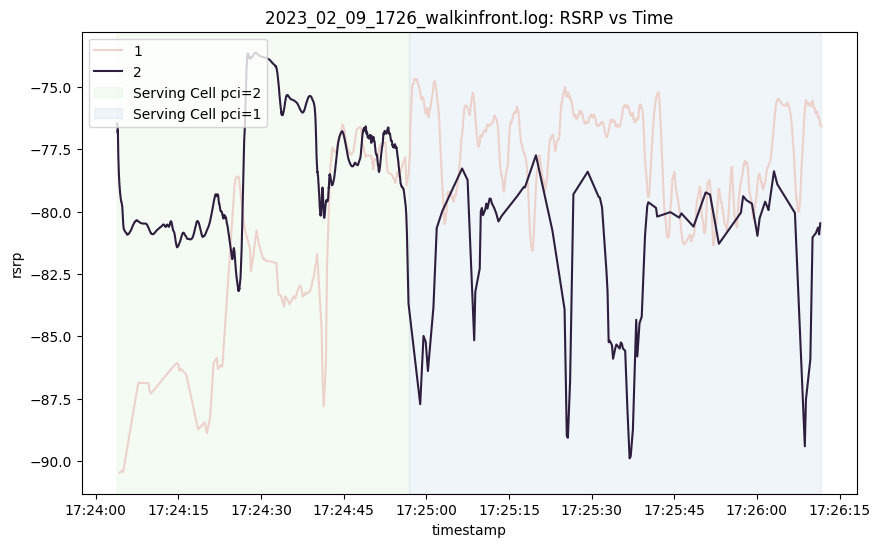

In [103]:
logfiles = sorted(
    [f"data/raw_logs/{x}" for x in os.listdir("data/raw_logs") if x.endswith(".log")]
)
for logfile in logfiles:
    logname = logfile.split("/")[-1]
    print(f"Plotting {logfile}:")
    log_data = get_measurement_data(logfile)
    smoothed_data = smoothed_rsrp(log_data, window_ms=1000)
    plot_rsrp_vs_time(
        smoothed_data, print_handover=True, title=f"{logname}: RSRP vs Time"
    )
    plt.show()